# Pretrain

To understand text, we can begin with its representation, such as treating each word or subword as an individual text token.

As we will see, the representation of each token can be pretrained on a large corpus, using word2vec, GloVe, or subword embedding models. After pretraining, representation of each token can be a vector. 

However, it remains the same no matter what the context is. Many more recent pretraining models adapt representation of the same token to different contexts. Among them is BERT.

![jupyter](../images/11/pretrain1.svg)

## word2vec

Previously, we use one-hot vectors to represent words, although they are easy to construct, they are usually not a good choice:

1. cannot accurately express the similarity between different words

2. dimension explosion

Word2vec is a tool that we came up with to solve the problem above.

The Word2vec tool contains two models: skip-gram and continuous bag of words (CBOW).

### skip-gram model

The skip-gram model assumes that a word can be used to generate the words surround it.

Assume that the text sequence is “the man loves his son”. We use “loves” as the central target word and set the context window size to 2

![jupyter](../images/11/skip-gram.svg)

the probability we concerned is:

$$P("the", "man", "his", "son"|"loves")$$

assume the context words are generated independently of each other:

$$P("the"|"loves")\cdot{P("man"|"loves")}\cdot{P("his"|"loves")}\cdot{P("son"|"loves")}$$

In the skip-gram model, each word is represented as two  $d$-dimension vectors.

* the central target vector $v_{i}$
* the context vector $u_{i}$

The conditional probability of generating the context word $w_{o}$ for the given central target $w_{c}$ word can be obtained by **performing a softmax operation on the vector inner product**:

$$P(w_{o}|w_{c}) = \frac{exp(u_{o}^{T}v_{c})}{\sum_{i\in{V}}exp(u_{i}^{T}v_{c})}$$

for a text sequence $\{w^{(1)},...,w^{(T)}\}$, the likelihood function of the skip-gram model of window size $m$:

$$\prod_{t=1}^{T}\prod_{-m\le{j}\le{m}, j\ne{0}}P(w^{(t+j)}|w^{(t)})$$

Here, any time step that is less than 1 or greater than  𝑇  can be ignored.

log-likelihood function:

$$\sum_{t=1}^{T}\sum_{-m\le{j}\le{m}, j\ne{0}}log\ P(w^{(t+j)}|w^{(t)})$$

$$log\ P(w_{o}|w_{c}) = u_{o}^{T}v_{c} - log\left(\sum_{i\in{V}}exp(u_{i}^{T}v_{c})\right)$$

if we use SGD, we can get the gradient with respect to $v_{c}$ from the formula above:

$$
\begin{equation}
\begin{split}
\frac{\partial log\ P(w_{o}|w_{c})}{\partial v_{c}} =& \frac{\partial\left( u_{o}^{T}v_{c} - log\left(\sum_{i\in{V}}exp(u_{i}^{T}v_{c})\right)\right)}{\partial v_{c}} \\
=& u_{o} - \frac{\sum_{i\in{V}}exp(u_{i}^{T}v_{c})u_{i}}{\sum_{i\in{V}}exp(u_{i}^{T}v_{c})} \\
=& u_{o} - \sum_{i\in{V}}P(w_{i}|w_{c})u_{i}
\end{split}
\end{equation}
$$

similarily, we can get the gradient with respect to $u_{o}$:

$$
\begin{equation}
\begin{split}
\frac{\partial log\ P(w_{o}|w_{c})}{\partial u_{o}} =& \frac{\partial\left( u_{o}^{T}v_{c} - log\left(\sum_{i\in{V}}exp(u_{i}^{T}v_{c})\right)\right)}{\partial u_{o}} \\
=& v_{c} - \frac{exp(u_{o}^{T}v_{c})v_{c}}{\sum_{i\in{V}}exp(u_{i}^{T}v_{c})} \\
=& v_{c} - P(w_{o}|w_{c})v_{c}
\end{split}
\end{equation}
$$

the gradient with respect to $u_{i}(i\ne{o})$:

$$\frac{\partial log\ P(w_{o}|w_{c})}{\partial u_{i}} = - P(w_{i}|w_{c})v_{c}$$

computational complexity of each gradient is $O(|V|)$.

generally we used $v_{c}$ as the representation vector of a word.

### continous bag of words(CBOW) model

the CBOW model assumes that the central target word is generated based on the context words.

![jupyter](../images/11/cbow.svg)

the probability we concerned is:

$$P("loves" | "the", "man", "his", "son")$$

Since there are multiple context words in the CBOW model, we will average their word vectors to compute the conditional probability.

In the CBOW model, each word is represented as two  $d$-dimension vectors.

* the central target vector $v_{i}$
* the context vector $u_{i}$

using softmax:

$$P(w_{c}|w_{o_{1}},...,w_{o_{2m}}) = \frac{exp\left(\frac{1}{2m}v_{c}^{T}(u_{o_{1}} + ... + u_{o_{2m}})\right)}{\sum_{i\in{V}}exp\left(\frac{1}{2m}v_{i}^{T}(u_{o_{1}} + ... + u_{o_{2m}})\right)}$$

likelihood functions and gradient update rule are then derived similarily.

unlike skip-gram, generally we used $u_{i}$ as the representation vector of a word

### Negative Sampling

to reduce computational complexity in gradient descent, we come up with the negative sampling method.

Recall the softmax conditional probability in skip-gram:

$$P(w_{o}|w_{c}) = \frac{exp(u_{o}^{T}v_{c})}{\sum_{i\in{V}}exp(u_{i}^{T}v_{c})}$$

for particular $(w_{o}, w_{c})$, we want to maximize $P(w_{o}|w_{c})$, that is to say we want:

1.$u_{o}^{T}v_{c}$ be large $\Leftrightarrow$ $\sigma(u_{o}^{T}v_{c})$ be large

2.$u_{i}^{T}v_{c} (i\ne{o})$ be small $\Leftrightarrow$ $\sigma(-u_{o}^{T}v_{c})$ be large

for the purpose of reduce computational complexity, instead of iterate all the "negative samples", we sample $K$ negative samples.

then instead of maximize:

$$\frac{exp(u_{o}^{T}v_{c})}{\sum_{i\in{V}}exp(u_{i}^{T}v_{c})}$$

we maximize:

$$\sigma(u_{o}^{T}v_{c})\prod_{k=1,w_{k}\sim{P(w)}}^{K}\sigma(-u_{i_{k}}^{T}v_{c})$$

in terms of log loss:

$$l(w_{o},w_{c}) = -log\ \sigma(u_{o}^{T}v_{c}) - \sum_{k=1,w_{k}\sim{P(w)}}^{K}log\ \sigma(-u_{i_{k}}^{T}v_{c})$$

now computational complexity of each gradient step is $O(|K|)$.

### dataset for Pretraining Word Embedding

#### Reading the Dataset

In [1]:
import math
import os
import random
import torch

import d2l

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]  # split to lines

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

#### subsampling

Generally speaking, in a context window, it is better to train lower-frequency words.

Therefore, when training the word embedding model, we drop out words depend on it's frequency:

$$f(w_{i}) = \frac{\mbox{number of word }w_{i} \mbox{ in the dataset}}{\mbox{total number of words in the dataset}}$$

The dropout probability is given as:

$$P(w_{i}) = \mbox{max}\left(1 - \sqrt{\frac{c}{f(w_{i})}}, 0\right)$$

where $c$ is a hyperparameter (set to  $10^{-4}$  in this experiment)

In [4]:
#@save
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
                 for line in sentences]
    # Count the frequency for each word
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if to keep this token during subsampling
    def keep(token):
        return (random.uniform(0, 1) < math.sqrt(
            1e-4 / counter[token] * num_tokens))

    # Now do the subsampling
    return [[tk for tk in line if keep(tk)] for line in sentences]

subsampled = subsampling(sentences, vocab)

subsampling significantly reduced the sequence length.

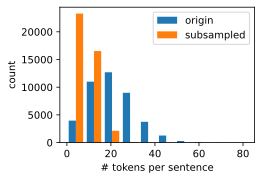

In [5]:
d2l.set_figsize()
d2l.plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]])
d2l.plt.xlabel('# tokens per sentence')
d2l.plt.ylabel('count')
d2l.plt.legend(['origin', 'subsampled']);

In [6]:
"""we map each token into an index to construct the corpus"""
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[], [71, 32, 2115, 406], [5277, 3054, 1580, 95]]

#### Extracting Central Target Words, Context Words and Negatives

In [7]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """Extracting Central Target Words and Context Words"""
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a "central target word
        # - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            # context window size uniformly between integer 1 and the max_window_size
            window_size = random.randint(1, max_window_size)
            indices = list(
                range(max(0, i - window_size),
                      min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [8]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}'

'# center-context pairs: 353046'

instead of calling random.choices every time. we define a RandomGenerator according to sampling_weights.

In [9]:
#@save
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(self.population,
                                             self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 2, 2, 2, 1, 1, 2, 1, 2, 1]

according to the original paper:

$$\mbox{sampling weight of }w_{i} \propto f(w_{i})^{0.75}$$

In [10]:
#@save
def get_negatives(all_contexts, corpus, K):
    counter = d2l.count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

#### Bachify

In [11]:
#@save
def batchify(data):
    """to specify the minibatch reading method in the DataLoader instance"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape(
        (-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks),
            torch.tensor(labels))

#### Combine All Things Together

In [12]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled = subsampling(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                            collate_fn=batchify,
                                            num_workers=0)  # set num_workers=0 to avoid error
    return data_iter, vocab

In [13]:
data_iter, vocab = load_data_ptb(512, 5, 5)

In [14]:
names = ['centers', 'contexts_negatives', 'masks', 'labels']
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


### Pretraining word2vec

In [15]:
import torch
from torch import nn

In [16]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype={embed.weight.dtype})


#### skip-gram model

In [17]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))  # (b, a, w) * (b, w, b) -> (b, a, b)
    return pred

In [18]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 3), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 3])

#### Binary Cross Entropy Loss Function

In [19]:
class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."

    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [20]:
pred = torch.tensor([[.5] * 4] * 2)
label = torch.tensor([[1., 0., 1., 0.]] * 2)
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)

tensor([0.7241, 0.3620])

In [21]:
loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]  # compute real mean loss

tensor([0.7241, 0.7241])

#### training

In [22]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),  # for central embedding
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))  # for context embedding

In [23]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)  # Sum of losses, no. of tokens
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (
                loss(pred.reshape(label.shape).float(), label.float(), mask) /
                mask.sum(axis=1) * mask.shape[1])  # a little different due to mask
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())  # numel Returns the total number of elements in the input tensor
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.373, 37292.3 tokens/sec on cpu


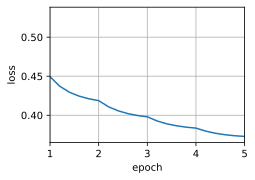

In [24]:
lr, num_epochs = 0.01, 5
train(net, data_iter, lr, num_epochs)

In [25]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    print(W.shape)
    x = W[vocab[query_token]]
    print(x.shape)
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(
        W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    print(cos.shape)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.idx_to_token[i]}')

get_similar_tokens('football', 3, net[0])

torch.Size([6719, 100])
torch.Size([100])
torch.Size([6719])
cosine sim=0.548: basketball
cosine sim=0.488: baseball
cosine sim=0.483: sports


## Global Vectors(Glove)